In [8]:
%load_ext autoreload
%autoreload 2

from pymongo import MongoClient
from bson.objectid import ObjectId

import analysis_utilities

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci': True}))

print("Found {} projects with a travis build status date".format(len(projects)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 685 projects with a travis build status date


In [13]:
prs_after_without_discussion = []
total = 0

for project in projects:
    pull_requests = list(pull_requests_collection.find({
        'project_name': project["full_name"].split("/")[1],
        'project_owner': project["full_name"].split("/")[0],
    }))
    
    prs_after = analysis_utilities.split_prs_on_build_date(project, pull_requests, field_name= "status_travis_date", days_delta = 0)[1]
    
    total += len(prs_after)
    
    prs_after_without_discussion.extend([pr for pr in prs_after if len(pr["review_comments"]) == 0 and len(pr["raw_comments"]) == 0])
    
print("We can analyze a total of {} after PRs, and {} PRs have no discussion".format(total, len(prs_after_without_discussion)))
    
    

We can analyze a total of 1000516 after PRs, and 277736 PRs have no discussion


In [14]:
prs_after_with_commits = []

for pr in prs_after_without_discussion:
    full_commits = list([commits_collection.find_one({'sha': commit_hash}) for commit_hash in pr["commits"]])
    
    if len([commit for commit in full_commits if "date" in commit and commit["date"] > pr["created_at"]]) > 0:
        prs_after_with_commits.append(pr)
        
print("There is a total of {} PRs without discussion, {} PRs have post create updates".format(len(prs_after_without_discussion), len(prs_after_with_commits)))
    

There is a total of 277736 PRs without discussion, 34414 PRs have post create updates


In [16]:
import random

for pr in random.sample(prs_after_with_commits, 10):
    print(pr["html_url"])

https://github.com/2600hz/kazoo/pull/3430
https://github.com/diaspora/diaspora/pull/5514
https://github.com/psychopy/psychopy/pull/1413
https://github.com/sensu/sensu/pull/475
https://github.com/Dolibarr/dolibarr/pull/9186
https://github.com/openscholar/openscholar/pull/10153
https://github.com/arangodb/arangodb/pull/6523
https://github.com/puma/puma/pull/1054
https://github.com/translate/pootle/pull/122
https://github.com/DynamoDS/Dynamo/pull/6149


In [17]:
for pr in random.sample(prs_after_with_commits, 10):
    print(pr["html_url"])

https://github.com/frappe/frappe/pull/4463
https://github.com/livecode/livecode/pull/1973
https://github.com/ets-berkeley-edu/calcentral/pull/672
https://github.com/musescore/MuseScore/pull/3063
https://github.com/2600hz/kazoo/pull/4737
https://github.com/caolan/async/pull/803
https://github.com/bem/bem-components/pull/1980
https://github.com/numpy/numpy/pull/3505
https://github.com/mozilla/shumway/pull/1579
https://github.com/Leaflet/Leaflet/pull/5506


In [18]:
for pr in random.sample(prs_after_with_commits, 10):
    print(pr["html_url"])

https://github.com/php/php-src/pull/1936
https://github.com/frappe/frappe/pull/4654
https://github.com/ros/rosdistro/pull/15421
https://github.com/forcedotcom/SalesforceMobileSDK-Android/pull/1414
https://github.com/wet-boew/wet-boew/pull/7511
https://github.com/joomla/joomla-cms/pull/1984
https://github.com/JuliaLang/julia/pull/12994
https://github.com/zeromq/libzmq/pull/2796
https://github.com/avalanche123/Imagine/pull/244
https://github.com/wikimedia/wikipedia-ios/pull/2274


In [23]:
for pr in random.sample(prs_after_with_commits, 10):
    print(pr["html_url"])

https://github.com/SupSuper/OpenXcom/pull/1107
https://github.com/Azure/azure-sdk-for-node/pull/3202
https://github.com/ariatemplates/ariatemplates/pull/1334
https://github.com/owncloud/android/pull/1270
https://github.com/geoserver/geoserver/pull/519
https://github.com/jquery/jquery-ui/pull/1798
https://github.com/bokeh/bokeh/pull/4529
https://github.com/frappe/erpnext/pull/12513
https://github.com/swagger-api/swagger-ui/pull/3829
https://github.com/EFForg/https-everywhere/pull/2734


In [38]:
failed_builds = 0
passed_builds = 0
errored_builds = 0


for pr in prs_after_with_commits:
    full_commits = list([commits_collection.find_one({'sha': commit_hash}) for commit_hash in pr["commits"]])
    
    for commit in full_commits:
        for status in commit["statuses"]:
            if "target_url" in status and status["target_url"] is not None and status["target_url"].startswith("https://travis-ci.org"):
                if status["state"] == "success":
                    passed_builds += 1
                elif status["state"] == "failure":
                    failed_builds += 1
                elif status["state"] == "error":
                    errored_builds += 1

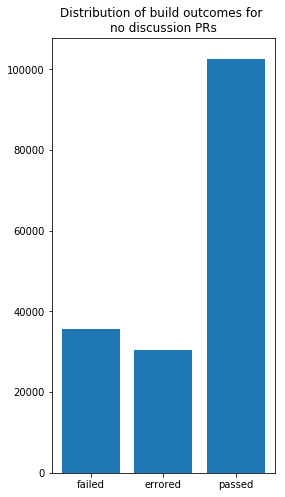

In [54]:

                    
import matplotlib.pyplot as plt 

fig = plt.figure(1, figsize=(4, 8))

# Create the boxplot
bp = plt.bar([0, 1, 2], [failed_builds, errored_builds, passed_builds])

plt.xticks([0, 1, 2], ['failed', 'errored', 'passed'])

plt.title("Distribution of build outcomes for \nno discussion PRs")

plt.show()

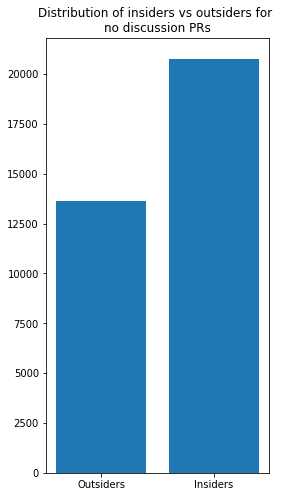

In [59]:
fig = plt.figure(1, figsize=(4, 8))

num_outsiders = len([pr for pr in prs_after_with_commits if pr["from_outsider"]])

# Create the boxplot
bp = plt.bar([0, 1], [num_outsiders, len(prs_after_with_commits) - num_outsiders])

plt.xticks([0, 1], ['Outsiders', 'Insiders'])

plt.title("Distribution of insiders vs outsiders for \nno discussion PRs")

plt.show()

In [42]:
per_project_builds = {}

for pr in prs_after_with_commits:
    full_commits = list([commits_collection.find_one({'sha': commit_hash}) for commit_hash in pr["commits"]])
    
    name = pr["project_owner"] + "/" + pr["project_name"]
    
    if name not in per_project_builds:
        per_project_builds[name] = {
            'passed' : 0,
            'failed': 0,
            'errored': 0,
            'prs': 0
        }
        
    res = per_project_builds[name]
    
    res["prs"] += 1
    
    for commit in full_commits:
        for status in commit["statuses"]:
            if "target_url" in status and status["target_url"] is not None and status["target_url"].startswith("https://travis-ci.org"):
                if status["state"] == "success":
                    res['passed'] += 1
                elif status["state"] == "failure":
                    res['failed'] += 1
                elif status["state"] == "error":
                    res['errored'] += 1

660 projects with no discussion, 301 projects with enough PRs


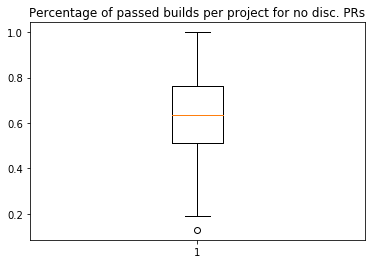

In [53]:
passed_builds_percentages = [item["passed"] / (item["passed"] + item["failed"] + item["errored"]) for item in per_project_builds.values() if item["prs"] > 20 and item["passed"] > 0]

print("{} projects with no discussion, {} projects with enough PRs".format(len(per_project_builds.values()), len(passed_builds_percentages)))

plt.figure()
plt.boxplot(passed_builds_percentages)

plt.title("Percentage of passed builds per project for no disc. PRs")

plt.show()


In [56]:
per_project_builds_merged = {}

for pr in prs_after_with_commits:
    
    if not pr["merged"]:
        continue
    
    full_commits = list([commits_collection.find_one({'sha': commit_hash}) for commit_hash in pr["commits"]])
    
    name = pr["project_owner"] + "/" + pr["project_name"]
    
    if name not in per_project_builds_merged:
        per_project_builds_merged[name] = {
            'passed' : 0,
            'failed': 0,
            'errored': 0,
            'prs': 0
        }
        
    res = per_project_builds_merged[name]
    
    res["prs"] += 1
    
    for commit in full_commits:
        for status in commit["statuses"]:
            if "target_url" in status and status["target_url"] is not None and status["target_url"].startswith("https://travis-ci.org"):
                if status["state"] == "success":
                    res['passed'] += 1
                elif status["state"] == "failure":
                    res['failed'] += 1
                elif status["state"] == "error":
                    res['errored'] += 1

638 projects with no discussion, 261 projects with enough PRs


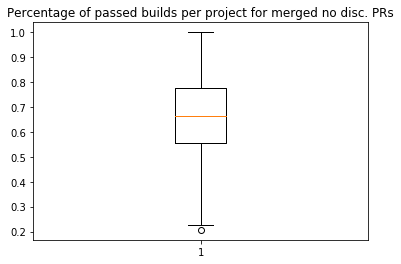

In [58]:
passed_builds_percentages = [item["passed"] / (item["passed"] + item["failed"] + item["errored"]) for item in per_project_builds_merged.values() if item["prs"] > 20 and item["passed"] > 0]

print("{} projects with no discussion, {} projects with enough PRs".format(len(per_project_builds_merged.values()), len(passed_builds_percentages)))

plt.figure()
plt.boxplot(passed_builds_percentages)

plt.title("Percentage of passed builds per project for merged no disc. PRs")

plt.show()
